Let's first install fastai library to make this notebook working. 
I am using GitHub codespace that has Github copilot installed. So you will see comments that I am using to use the copilot. 

In [15]:
#requirements.txt is not working with .devcontainer. Need to figure it out
# %pip install fastai ipywidgets matplotlib torch; 
%pip install -q -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [16]:
# check the installed versions of fastai, ipywidgets, matplotlib, torch
%pip list


Package                  Version
------------------------ ------------
anyio                    3.7.0
argon2-cffi              21.3.0
argon2-cffi-bindings     21.2.0
arrow                    1.2.3
asttokens                2.2.1
async-lru                2.0.2
attrs                    23.1.0
Babel                    2.12.1
backcall                 0.2.0
beautifulsoup4           4.12.2
bleach                   6.0.0
blis                     0.7.9
catalogue                2.0.8
certifi                  2023.5.7
cffi                     1.15.1
charset-normalizer       3.1.0
click                    8.1.3
cmake                    3.26.3
colorama                 0.4.6
comm                     0.1.3
confection               0.0.4
contourpy                1.0.7
cryptography             41.0.1
cycler                   0.11.0
cymem                    2.0.7
debugpy                  1.6.7
decorator                5.1.1
defusedxml               0.7.1
exceptiongroup           1.1.1
executing         

Jeremy's notebook uses a function to explain how to calculate gradient descent. 
First, let's define a function that plot a functionin a given quadrant. I am directly using the code from the Jeremy's notebook.

In [17]:
from ipywidgets import interact
from fastai.basics import *

plt.rc('figure', dpi=90)

def plot_function(f, title=None, min=-2.1, max=2.1, color='r', ylim=None):
    x = torch.linspace(min,max, 100)[:,None]
    if ylim: plt.ylim(ylim)
    plt.plot(x, f(x), color)
    if title is not None: plt.title(title)

I am going to define a quadratic function and use it to explain the gradient descent mechanism as it is an easy function that many people can intuitively understand. 

The big idea here is - create data points that kind of fit like a quadratic function, adjust the coefficients of the quadratic function to make a new quadratic function that can capture the data quite well. 

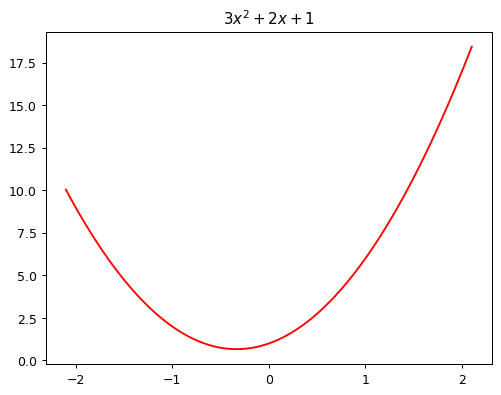

In [18]:
def f(x): return 3*x**2 + 2*x + 1

plot_function(f, "$3x^2 + 2x + 1$")

In [19]:
# Create a function that accepts coefficients of a quadratic function and a value for x and retunrs the value of the quadratic function.
def quadratic(a, b, c, x):
    return a*x**2 + b*x + c

# call the above quadratic function with the coefficients of the quadratic function f(x) and a value for x.
quadratic(3, 2, 1, 2)

17

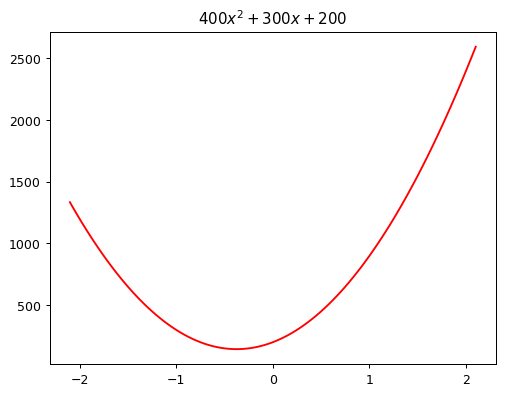

In [20]:
# what is partial in python?
# https://www.geeksforgeeks.org/partial-functions-python/
# why should I use partial instead of just passing the coefficients of the quadratic function to the quadratic function?
# https://stackoverflow.com/questions/15331726/how-does-functools-partial-do-what-it-does 
# What I am hearing is: I can fix the coefficients of the quadratic function, and it is sometime useful as I can create a wrapper on top of it and pass it as a single parameter. 

#create another function using python partial of the above quadratic function.
def quadratic_partial(a, b, c):
    return partial(quadratic, a, b, c)

# plot the quadratic function using the quadratic_partial function.a=400, b=300, c=200
plot_function(quadratic_partial(400, 300, 200), "$400x^2 + 300x + 200$")

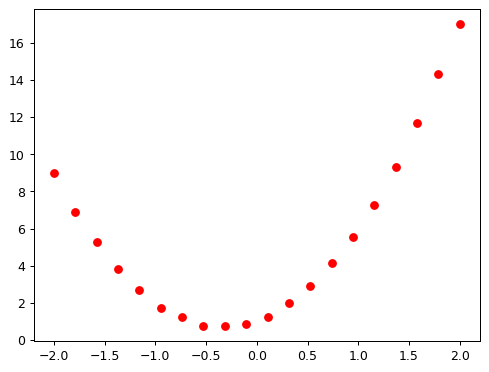

In [21]:
# Create a set of data points with some noises that follow the quadratic function f(x).
x = torch.linspace(-2, 2, 20)
y = f(x) + torch.randn(x.size()) * 0.1

# plot the data points
plt.scatter(x, y, color='r')

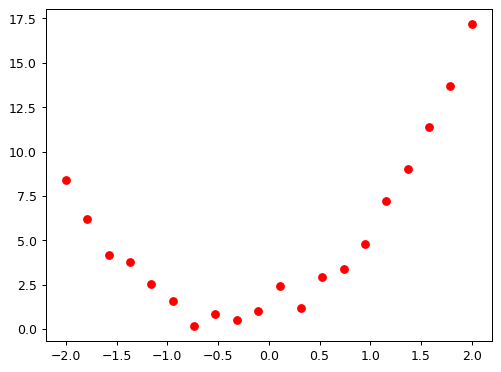

In [22]:
# Add some more noises in the above data points.
y = f(x) + torch.randn(x.size()) * 0.5

# plot the data points
plt.scatter(x, y, color='r')


In [23]:
# print out a few of X and Y values.
x[:5], y[:5]

(tensor([-2.0000, -1.7895, -1.5789, -1.3684, -1.1579]),
 tensor([8.3809, 6.2089, 4.1490, 3.7956, 2.5194]))

In [24]:
# There is no rank function in pytorch. Get a rank of a tensor using len function.
len(x.shape), len(y.shape)
# What is rank 1 tensor?   
# https://stackoverflow.com/questions/44747408/what-is-a-rank-1-tensor // the link does not exist. 
# [Research] What is rank? (come from the textbook)


(1, 1)

Okay, now we have data that we artifically created. And let's assume our model (function) is a quadratic function*. 
Let's overlay the function over our data. 
*We will see how to start with our model using a very flexible function at the end of this section.  

In [25]:
@interact(a=1, b=-3, c=-2,d=-1)
# create a function that accepts a, b, c and plot the quadratic_partial function with a, b, c. Scatter the data points on the same plot.
def plot_quadratic(a, b, c):
    plot_function(quadratic_partial(a, b, c), "$ax^2 + bx + c$", color='r')
    plt.scatter(x, y, color='b')

interactive(children=(IntSlider(value=1, description='a', max=3, min=-1), IntSlider(value=-3, description='b',…

To fit the function onto our data, we just interact with different coefficient values. 
But let's really think through how we are doing so. 
(1) We try to move each coefficient a bit to left or right to see whether the result is better or not. 
(2) After iterating through all parameters, we go back and try to adjust to imporve a bit better. 

Though we can intuitively sense that the function is fitting better at data as we change coefficeints, it is really hard to tell if there is not noticeable improvement, but still there is imporvement.

This is why we need to have a metric that can tell us that our change is aligning to a better result or not. 
Better means that the prediction is close to the actual data. 
Here, the actual data is y. The prediction is the value of quadratic_partial.

To calculate how close the prediction is to the actual data point is cacluating the distance between the two dots. Therefore, using mean absolute error* is a function we are going to use.

[Research](When to use mean absolute error)

In [26]:
def mae(preds, acts): return (torch.abs(preds-acts)).mean()
@interact(a=1.1, b=1.1, c=1.1)
def plot_quad(a, b, c):
    f = quadratic_partial(a,b,c)
    plt.scatter(x,y)
    loss = mae(f(x), y)
    plot_function(f, ylim=(-3,12), title=f"MAE: {loss:.2f}")

interactive(children=(FloatSlider(value=1.1, description='a', max=3.3000000000000003, min=-1.1), FloatSlider(v…

In [27]:
# define mean absolute error function.
def mae(y_hat, y): return (y_hat - y).abs().mean()

# define y_hat using quadratic_partial function with a=4, b=-3, c=-2
y_hat = quadratic_partial(4, -3, -2)(x)

# create a function that accepts a, b, c and plot the quadratic_partial function with a, b, c. Scatter the data points on the same plot. Also show the result of mean absolute error function.
@interact(a=1, b=-3, c=-2,d=-1)
def plot_quadratic(a, b, c):
    y_hat = quadratic_partial(a, b, c)(x)
    plot_function(quadratic_partial(a, b, c), "$ax^2 + bx + c$", color='r')
    plt.scatter(x, y, color='b')
    plt.scatter(x, y_hat, color='g')
    print('mae:', mae(y_hat, y).item())

interactive(children=(IntSlider(value=1, description='a', max=3, min=-1), IntSlider(value=-3, description='b',…

I updated the coefficients iteratively relying on mae value. I updated the coefficients to the values to minimize mae.
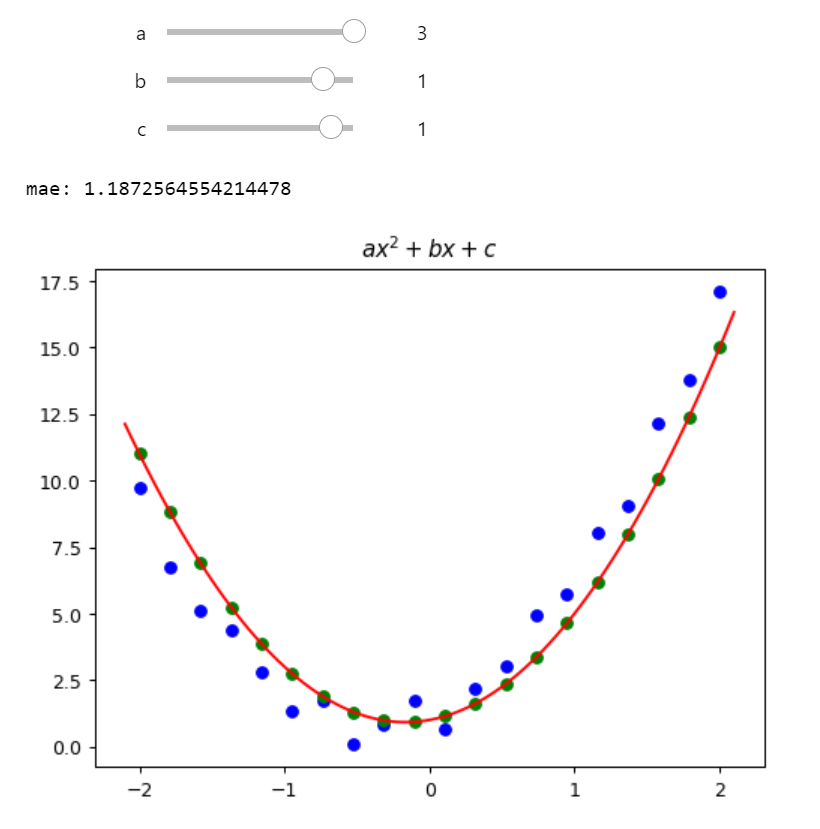 

But this is very manual. In real life, when we have millions of parameters, we cannot ddeploy the same approach. So we will need to automate this. How can I automate this? 


To automate we are going to use calculas. Specifically speaking, we are going to use gradient. The learning algorithm is called gradient descent as to minimize our function (loss function), we are going the opposite direction of gradient (you can see where descent concept is coming from?).

First, we need to define the loss function in relative to parameters (coefficients in our case).

In [28]:
def quad_loss(params):
    preds = quadratic_partial(*params) # this is a function
    return mae(preds(x),y) # preds(x) = this is a tensor.
    # return mae(preds, y) // this will return an error: TypeError: unsupported operand type(s) for -: 'functools.partial' and 'Tensor'

Params here are a,b,c. Let's represent them in rank 1 tensor. Initialize it with random values. 
It is important to represent params as a tensor as the tensor provides useful methods to calculate gradients of each parameter. 

In [29]:
abc = torch.tensor([1.1, 1.1, 1.1]) #this is one variable, each of element rerepsent a parameter.
abc, abc.grad

(tensor([1.1000, 1.1000, 1.1000]), None)

Okay now tell pytorch that we want to take gradients of those parameters. 

In [30]:
abc.requires_grad_() # this is a tensor that requires gradient.
abc, abc.grad

(tensor([1.1000, 1.1000, 1.1000], requires_grad=True), None)

Now take gradient descent to minimize the loss. 
As the loss function is related to the parameters, when we backward (taking gradients in pytorch world), we will get the gradients of the parameters we are intrested in.

In [31]:
loss = quad_loss(abc)
loss 

tensor(2.5473, grad_fn=<MeanBackward0>)

In [32]:
loss.backward() #taking gradient descent of the loss function.

Now check the gradients of the parameters (one tensor in our case). Now each parameter (each element in the tensor) does have a gradient. But remember, for us, the gradient is useful to know the direction. We are not going to use the magnitude of the gradient as it is. It is because we want to find the local minima of the loss function. Therefore if we change the value of parameters too large, we can easily miss the local minima. We want to go very little step per time. 

In [33]:
abc, abc.grad

(tensor([1.1000, 1.1000, 1.1000], requires_grad=True),
 tensor([-1.3994, -0.0737, -0.7000]))

These values are telling us that each of parametr needs to slightly be increased. So we are going to update the parameters value. Two important points to remember are -

(1) As we discussed earlier, we are using the direction, not the magnitude. The magnitude of the change is going to be very small because I am going to multiply with a learning rate, which is a very small value.  

(2) We don't want to track this calculation in pytorch. 
- This requires a bit more context. So pytorch keeps track of all operations that we carry over with our tensors. As soon as we say "hey these tensors, we are interested in calculating gradients" by setting up the flag (requires_grads), Pytroch will save all the operations related to those tensors, and will use them to take the derivative. 

If we save the process of updating the tensor values, the operation can potentially affect the process of taking gradient. In otherwords, the operation of updating the parameters is not related to calculating the derivative of the loss function. So we need to let the pytorch know that "hey don't track this part". How do so? By doing `with torch.no_grad():`. 

The post that I got help: https://forums.fast.ai/t/what-does-torch-no-grad-mean/72355

In [34]:
# temporary set requires_grad to false.
with torch.no_grad():
    # update the parameters using gradient descent.
    abc -= abc.grad * 1e-3
    loss = quad_loss(abc)

In [35]:
loss

tensor(2.5449)

Before taking gradient descent: 
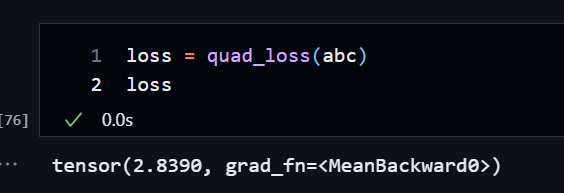



After: 
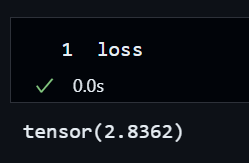

And we can see the loss value is lower! 

What we just did is going through one layer of neural network. Usually we want to do multiple iterations to find better values for parameters. 

In [36]:
# reinitialize abc to accurately show the process. 
abc = torch.tensor([1.1, 1.1, 1.1]).requires_grad_()

# create a for loop to update the parameters using gradient descent.
for i in range(10):
    # caclculate the loss using the randomly initailized parameters (input data is coming from the plot.scatter function)
    loss = quad_loss(abc)

    # taking gradient descent of the loss function.
    loss.backward()
    with torch.no_grad():
        # updating the parameters using gradient descent.
        abc -= abc.grad * 1e-3
        abc.grad.zero_()
    # print out the loss and the iteration number. 
    print(loss.item(), i)


2.5473291873931885 0
2.544875383377075 1
2.542421340942383 2
2.5399677753448486 3
2.5375139713287354 4
2.535060167312622 5
2.532606363296509 6
2.5301523208618164 7
2.5276987552642822 8
2.525244951248169 9


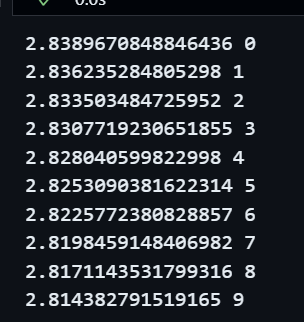

As you can see the loss value decreases as we iterate more (the right column shows the iteration number). 

So in summary, we artifically created a dataset that fits into a quadratic function to show how gradient descent works to update the parameters of a function. 

In this case, we knew our function. But in real life, we won't know what function will best fit into the dataset that is present to us. Always using a quadratic function isn't flexible for us to solve many problems out there, as not all datasets will nicely fit into a quadratic function. 

Then what should we do? 

Well, we need to start with a function that is very flexible, which can fit into the given dataset as we iterate more to update parameters. 

It logically makes sense. But how do we define a very flexible function? 

This is where the concept of reLu function comes in. 
IMO, a reLu function is a fancy way of saying a non-linear function. When we combine non-linear functions, we can creeate a flexible function. 

The mathematical representation of a reLu function is a very straightforward. 
[Research] reluFucntion

Now we have data that seems like a quadratic function, but we do not know what coefficients we need. 
One manual way to figure this out is to play around with it. But still we need a starting point. 
This quadratic function does look like a combination of rectified linear function*. 
So we are going to create a double reLu. 


In [37]:
def reLu(*params):
    y = x*(params)+b
    # make the negative value of the function to be zero. 
    return torch.clip(y)

We can create a very flexible function (our model) by adding mutiple reLU functions. 
Check below code that I created with CoPilot to mimic a quadratic function by using two reLu functions. 

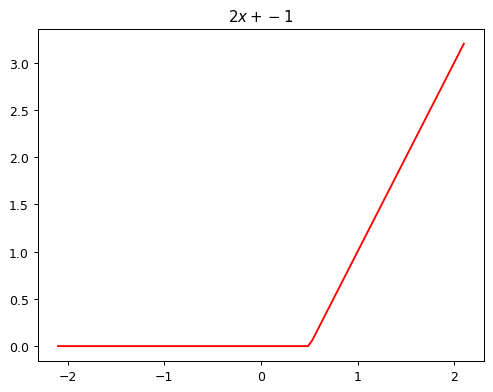

In [38]:
# Create a function that combines two rectified linear functions.
# Step 1: define relu function.
def relu(x, a, b):
    y = x*a+b
    return torch.clamp(y, min=0.)
    #return x.clamp_min(0.) * a + b
# what is clamp_min function?
# https://pytorch.org/docs/stable/generated/torch.clamp_min.html

# plot the relu function with a=2, b=-1
plot_function(partial(relu, a=2, b=-1), "$2x + -1$")

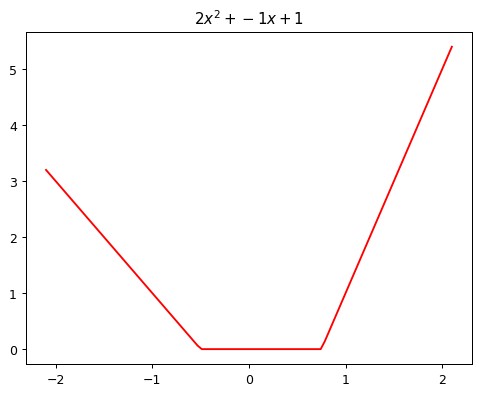

In [39]:
# Create two relu functions and combine them to create a quadratic function.
def quad_relu(x, a, b, c, d):
    return relu(x, a, b) + relu(x, c,d)

# plot the quad_relu function with a=2, b=-1, c=1
plot_function(partial(quad_relu, a=4, b=-3, c=-2, d=-1), "$2x^2 + -1x + 1$")

In [40]:
# make plot_function interactive. 
# https://ipywidgets.readthedocs.io/en/latest/examples/Using%20Interact.html
from ipywidgets import interact

@interact(a=1, b=-3, c=-2,d=-1)
# create a function that accepts a, b, c, d and plot the quad_relu function with a, b, c, d. Scatter the data points on the same plot.
def plot_quad_relu(a, b, c, d):
    plot_function(partial(quad_relu, a=a, b=b, c=c, d=d), "$2x^2 + -1x + 1$", ylim=(-3,13))
    plt.scatter(x, y, color='r')

interactive(children=(IntSlider(value=1, description='a', max=3, min=-1), IntSlider(value=-3, description='b',…

Okay so now we have an idea about (1) how to come up with a very flexible function. 
(2) The next is coming up with a list of parameters. 

You can come up with a list of parameters based on the dataset. You will identify the number of inputs and the corresponding parameters. Then you will randomly initialize the parameters for each reLu function. 

Then now this means (3) you can calculate a dependent variable for each reLu, even if the depednent value is far from the truth. 
Calculate the dependent variable for each reLU and sum them up. The sum is the prediction from your model. 

After getting a prediction from your model, now (4) you need to come up with the loss function. 
Loss function by definition, is a fucntion that measures how performant your model is by comparing the prediction that your model calcaultes from the training data and the actual label. There might be fancier ways to calculate this, but at this point, eitehr using the mean absolute error (MSE) or the square error is good enough.

[Research] MSE and the other method. 

After you define a loss function, now it is (5) to calculate gradients. 
If you are using pytorch, represent the parameters in tensors, and mark the require_grad flags so pytorch can take the gradient of those parameters when it does backtrace. 

(6) then update the parameters using the graident. Use the gradient descent algorithm which uses the direction of the gradient to change the parmeter values. We are using the learning rate to determine how much we want to change each parametr. 

(7) Then repeat the process a few times until we hit the local minima of the loss function. 

Now let's try to apply what we learned here to the Tatianc dataset. 